# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 30 Oktober 2023



## Loading of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import pickle
import warnings
import time
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Importing the data

In [2]:
df = pd.read_csv('./data/231030_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,manv,date,is_holiday,holiday,datetime,actp,num_veh,etatp,day_of_week,hour_of_day
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,11.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,0,0,5,1
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,0.0,2019-11-30,False,NaN,2019-11-30 02:50:00,0,0,0,5,2
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,2.0,2019-11-28,False,NaN,2019-11-28 15:15:00,1,0,0,3,15


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  hrmn         object 
 11  lum          int64  
 12  agg          int64  
 13  int          int64  
 14  atm          float64
 15  col          float64
 16  dep          int64  
 17  catr         float64
 18  circ         float64
 19  nbv          float64
 20  vosp         float64
 21  prof         float64
 22  plan         float64
 23  surf         float64
 24  infra        float64
 25  situ         float64
 26  senc         float64
 27  catv         int64  
 28  occutc       float64
 29  obs          float64
 30  obsm         float64
 31  choc         

### Missing data

In [5]:
df.isna().sum()

place                0
catu                 0
grav                 0
sexe                 0
an_nais              0
trajet               0
locp                 0
an                   0
mois                 0
jour                 0
hrmn                 0
lum                  0
agg                  0
int                  0
atm                  0
col                  0
dep                  0
catr                 0
circ                 0
nbv                  0
vosp                 0
prof                 0
plan                 0
surf                 0
infra                0
situ                 0
senc                 0
catv                 0
occutc               0
obs                  0
obsm                 0
choc                 0
manv                 0
date                 0
is_holiday           0
holiday        2367768
datetime             0
actp                 0
num_veh              0
etatp                0
day_of_week          0
hour_of_day          0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant
- `datetime`: was required to create other datetime variables
- `hrmn`: was required to create time related variables

In [6]:
columns_drop = ['holiday', 'hrmn', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv         

## Data preparation
### Encode or drop date variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Fix `date` variable and transform to `integer`.

In [8]:
df = df.assign(date = pd.to_datetime(df['date']))
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv         

In [10]:
columns = df.columns.sort_values()
df = df[columns]

In [11]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

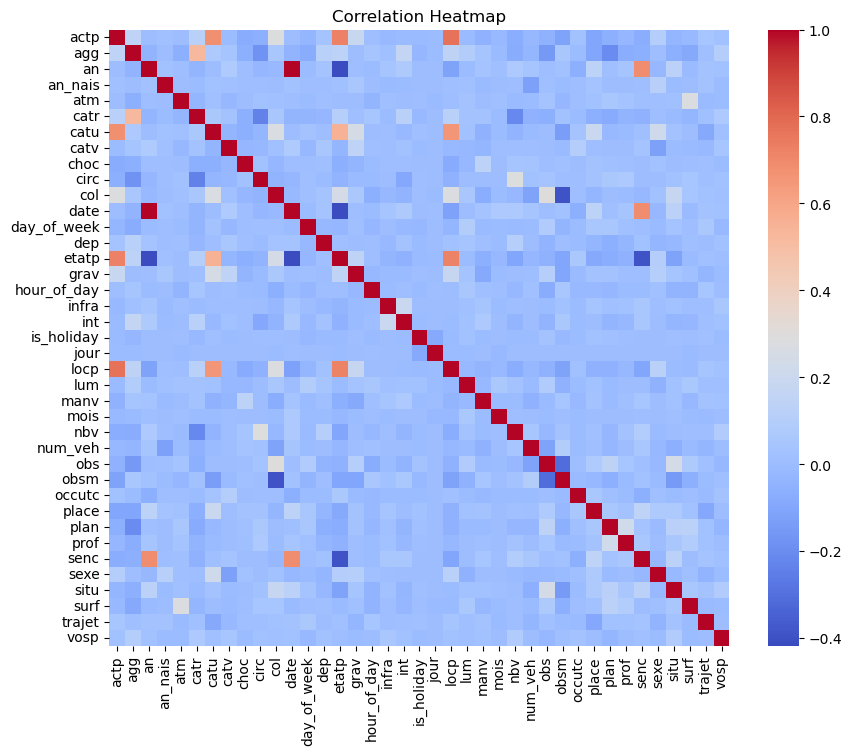

In [12]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

The correlation matrix shows some inter-variable correlations, but no real importance of variables to predict the target `grav`. 

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.


In [13]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2020].drop('grav', axis = 1)
X_test = df.loc[df['an'] > 2019].drop('grav', axis = 1)

y_train = df['grav'].loc[df['an'] < 2020]
y_test = df['grav'].loc[df['an'] > 2019]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a XGBoost Classification Model with Tree-based Parzen Estimators optimisation
The Tree-based Parzen Estimator (TPE) [1] optimisation combines a Bayesian Sequential Model Based Optimisation (SMBO) and a random search on the hyperparemeter grid[2]. While the random search is a static approach, the SMBO optimises the model using prior runs to determine future points of exploration.

The package `hyperopt` [4] is used for optimisation. The hyperparameter optimisation code is written based on ideas in [5].

#### The tuning space
`hyperopt` uses a specific format of parameters expressions [7]. Hints on the parameter ranges are given in [1,5,7].

The `booster` in this first model is `gbtree`. The evaluation metric is `logloss` or `auc`[8].

Another classification method is Dropout with Multiple Additive Regression Trees (`dart`)[9], which is not used here.

The metric used is `mlogloss` (as a special case of `logloss` for multiclass modelling). The reason is that `logloss` is an absolute measure of the quality of the classification, while `auc` is a simple ranking function [10]. `logloss` is discussed as better performing with imbalanced datasets [11].


In [14]:
# Create the tuning space
booster = 'gbtree'
eval_metric = 'mlogloss'

tuning_space={
    'eta': hp.uniform('eta', 0, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1), # default is 100, so we try to check in the one magnitude space
    'seed': 123,
    'early_stopping_rounds': 10, # stop tuning early to avoid overfitting
    'objective': 'binary:logistic',
    'subsample': hp.uniform('subsample', 0, 1)
    }

tuning_space.update({'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2)}) # helps in auc
tuning_space.update({'max_delta_step': hp.uniform('max_delta_step', 0, 2)}) # helps in auc
tuning_space.update({'eval_metric': eval_metric})
tuning_space.update({'booster': booster})


#### The tuning function
The following function integrates all steps required for the hyperoptimization tuning. The results are stored in the model and the tuning score is printed per step.

In [15]:
# Function for the classification
def hp_xgbclass(space, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """ Function for Bayesian hyperparameter optimisation of XGboost classification model.
    Accepts a parameter `space` and the training and testing data set.
        :param tuning_space: a catalog containing the parameters used for hyperparameter tuning, ranges given in hp objects
        :param X_train: accepts the train data
        :param X_test: accepts the test data
        :param X_eval: accepts the eval data used for optimisation
        :param y_train: accepts the train target
        :param y_test: accepts the test target
        :param y_eval: accepts the eval data used for optimisation
    """

    if (space['objective'] == 'binary:logistic') and (space['booster'] == 'gbtree'):
        clf=xgb.XGBClassifier(
            eta = space['eta'],
            eval_metric = space['eval_metric'],
            booster = space['booster'],
            n_estimators = np.int64(space['n_estimators']),
            max_depth = np.int64(space['max_depth']),
            gamma = space['gamma'],
            reg_alpha = space['reg_alpha'],
            min_child_weight=np.int64(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            colsample_bylevel=space['colsample_bylevel'],
            colsample_bynode=space['colsample_bynode'],
            early_stopping_rounds = space['early_stopping_rounds'],
            objective = space['objective'],
            # scale_pos_weight = space['scale_pos_weight'], # not used in this model
            max_delta_step = space['max_delta_step'],
            subsample = space['subsample']
    
        )
          
    clf.fit(X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            verbose=False)
        
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

#### The tuning
In this section, the hyperparameter tuning is performed. The results are stored in the trial db and the hyperparameter file for later re-use. In case, the downstream analysis is changed, the model could be loaded in this section.

In [16]:
# Running the crossvalidation or load stored parameters

# lets check the run time
start_time = time.monotonic()

# Suppress warnings because of deprecated functions or parameters, we cannot influence
warnings.filterwarnings('ignore')

# Rerun (True) or get stored parameters (False)
cv_rerun = True

# define the stored files
out_file_trial = './data/XGboost_model/231030_XGboost_gbtree_mlogloss_grav_non_encoded.pkl'
out_file_params = './data/XGboost_model/231030_XGboost_gbtree_mlogloss_hyperparameters_grav_non_encoded.pkl'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                            space = tuning_space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials,
                            verbose=0
                           )
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open(out_file_params, 'rb') as f:
        best_hyperparams = pickle.load(f)

# Track the end of the tuning
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

SCORE: 0.36122525552526774
SCORE: 0.3668624073848046
SCORE: 0.35848578958550886
SCORE: 0.3603844293457378
SCORE: 0.35891072324613155
SCORE: 0.36057429332176066
SCORE: 0.3369678723029144
SCORE: 0.3605200464714684
SCORE: 0.36282553760888925
SCORE: 0.3578077039568557
SCORE: 0.3650993847503063
SCORE: 0.3603392236371609
SCORE: 0.3626447147745817
SCORE: 0.36351266437925783
SCORE: 0.3598464814136729
SCORE: 0.3607777190103566
SCORE: 0.3603799087748801
SCORE: 0.3654565098480636
SCORE: 0.3485540954111685
SCORE: 0.36223786339738984
SCORE: 0.36873844429074504
SCORE: 0.3688650202747603
SCORE: 0.36397828317759967
SCORE: 0.3681055643706687
SCORE: 0.3601312773777073
SCORE: 0.36136991379271377
SCORE: 0.36436253170050314
SCORE: 0.36606226634299377
SCORE: 0.3560085167554959
SCORE: 0.36144676349729443
SCORE: 0.3682004963586802
SCORE: 0.35900113466328526
SCORE: 0.3645614368182414
SCORE: 0.3654248658520598
SCORE: 0.3636301992215577
SCORE: 0.360642101884626
SCORE: 0.38969129021612847
SCORE: 0.362943072451189

In [17]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.13916172156921344, 'colsample_bynode': 0.5609995120100892, 'colsample_bytree': 0.88005624395239, 'eta': 0.0009396302045719066, 'gamma': 4.446026648388206, 'max_delta_step': 0.6537071950869053, 'max_depth': 3.0, 'min_child_weight': 7.0, 'n_estimators': 379.0, 'reg_alpha': 53.53086175842188, 'reg_lambda': 6.203432248506015, 'scale_pos_weight': 1.8763895410447775, 'subsample': 0.7043278066598938}


In [19]:
# lets check the run time
start_time = time.monotonic()

out_file_model = './data/XGboost_model/231030_XGboost_model_gbtree_mlogloss_grav_non_encoded.pkl'

if(cv_rerun == True):
    xgb_1 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree']
            
        )
    
    xgb_1 = xgb_1.fit(X_train,
              y_train,
              eval_set = [(X_test, y_test)], 
              verbose = False)

    # Dump the model for reuse
    with open(out_file_model, 'wb') as f:
        pickle.dump(xgb_1, f)

else:
    with open(out_file_model, 'rb') as f:
        xgb_1 = pickle.load(f)

# Track the end of the modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:04:29.430866


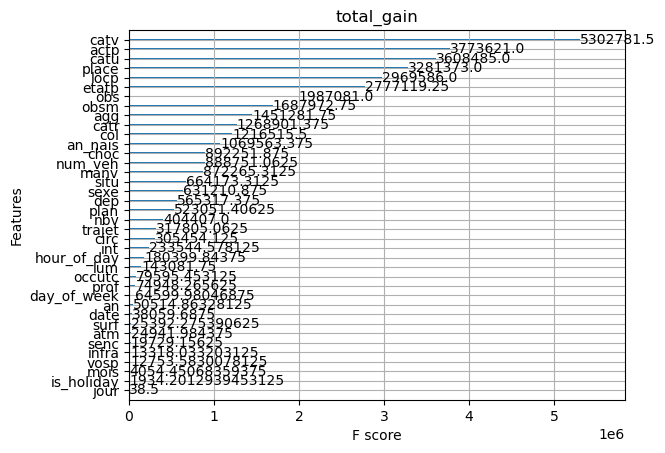

<Figure size 1600x1200 with 0 Axes>

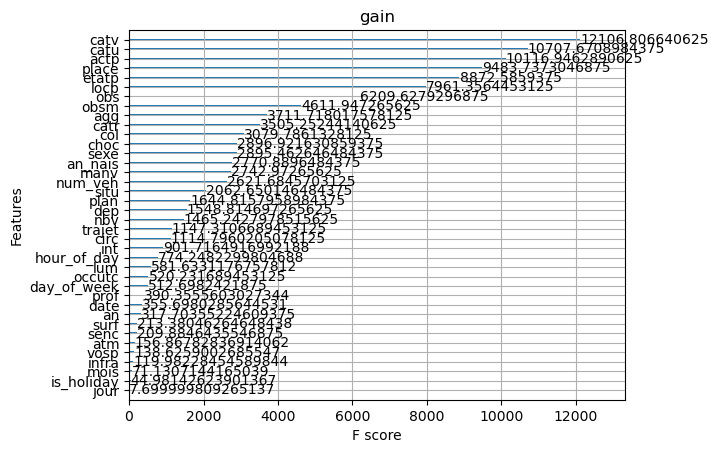

<Figure size 1600x1200 with 0 Axes>

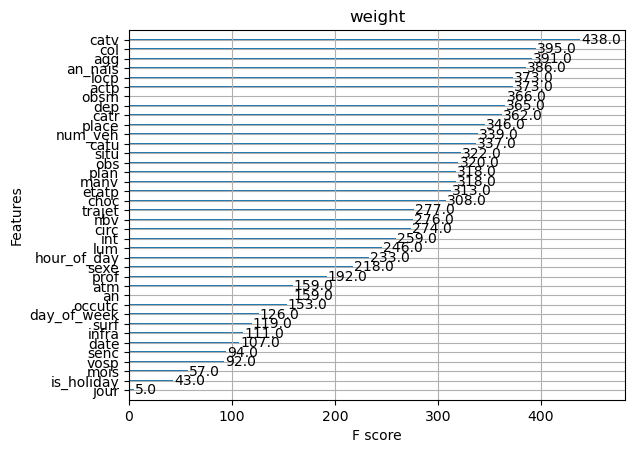

<Figure size 1600x1200 with 0 Axes>

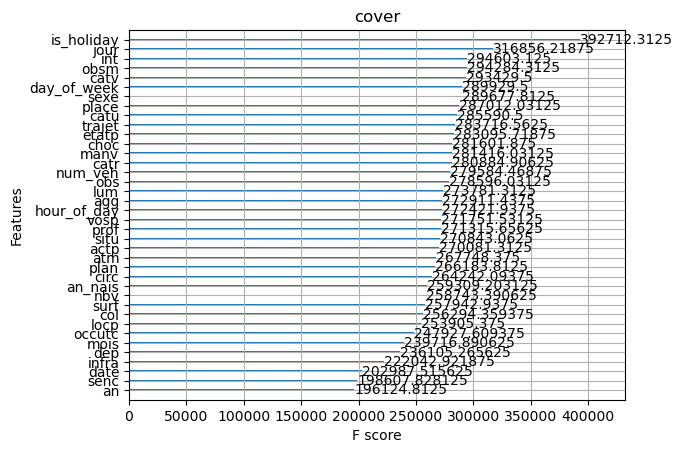

<Figure size 1600x1200 with 0 Axes>

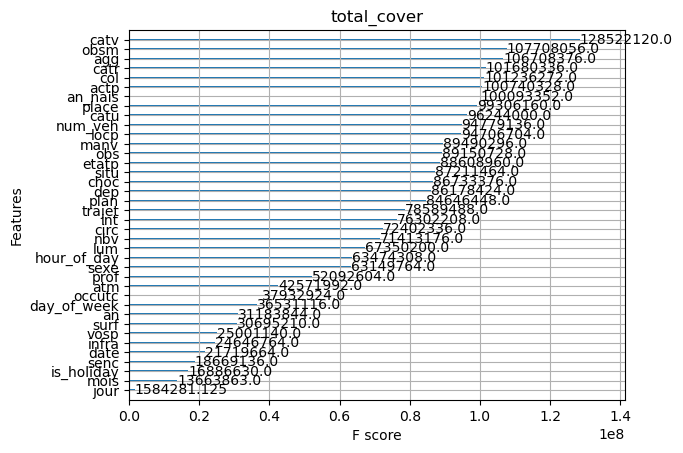

<Figure size 1600x1200 with 0 Axes>

In [20]:
importance_types = ['total_gain', 'gain', 'weight', 'cover', 'total_cover']

for f in importance_types:
    xgb.plot_importance(xgb_1, max_num_features=50, importance_type=f, title=f)
    plt.figure(figsize = (16, 12))
    plt.show();

In [21]:
y_pred = xgb_1.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.50      0.66    178615
           1       0.00      0.00      0.00         0
           2       0.00      0.62      0.00        37
           3       0.28      0.59      0.38     42559

    accuracy                           0.51    221211
   macro avg       0.31      0.43      0.26    221211
weighted avg       0.83      0.51      0.60    221211

col_0      0     1      2      3
row_0                           
0      88942  3574  21636  64463
2          0     7     23      7
3       3949  1904  11786  24920


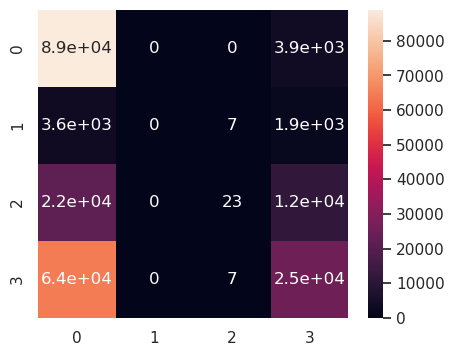

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5, 4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True);

In [23]:
from xgboost import plot_tree
import graphviz
plot_tree(xgb_1)
plt.show()


ModuleNotFoundError: No module named 'graphviz'

## References
[1] [Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

[2] https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa

[3] https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

[4] https://github.com/hyperopt/hyperopt

[5] https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[6] https://github.com/hyperopt/hyperopt/wiki/FMin

[7] https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

[8] https://www.datamachines.io/blog/auc-vs-log-loss

[9] [Rashmi, K.V., Gilad-Bachrach (2015) DART: Dropouts meet Multiple Additive Regression Trees. arXiv:1505.01866v](https://doi.org/10.48550/arXiv.1505.01866)

[10] https://datamachines.com/blog/auc-vs-log-loss

[11] https://stats.stackexchange.com/questions/322408/logloss-vs-gini-auc